In [1]:
import random, os, tqdm, time, json
import numpy as np
import pandas as pd
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

import sys
sys.path.append("../../")

random.seed(618)
np.random.seed(907)

new_base_path = os.path.join(
    "/mnt/d/forCoding_data",
    "/".join(
        os.getcwd().split("/")[-1*(len(sys.path[-1].split("/")) - 1):]
    ),
)
print("storage dir:", new_base_path)
print("code dir:", os.getcwd())

## 创建文件夹。
if not os.path.exists(new_base_path):
    os.makedirs(
        new_base_path
    )
if not os.path.exists(os.path.join(new_base_path, "preprocessedData")):
    os.makedirs(
        os.path.join(new_base_path, "preprocessedData")
    )
if not os.path.exists(os.path.join(new_base_path, "originalData")):
    os.makedirs(
        os.path.join(new_base_path, "originalData")
    )
if not os.path.exists(os.path.join(new_base_path, "trained_models")):
    os.makedirs(
        os.path.join(new_base_path, "trained_models")
    )

def create_originalData_path(filename_or_path):
    return os.path.join(new_base_path, "originalData", filename_or_path)
def create_preprocessedData_path(filename_or_path):
    return os.path.join(new_base_path, "preprocessedData", filename_or_path)
def create_trained_models_path(filename_or_path):
    return os.path.join(new_base_path, "trained_models", filename_or_path)

def millisec2datetime(timestamp):
    time_local = time.localtime(timestamp/1000)
    return time.strftime("%Y-%m-%d %H:%M:%S", time_local)
    
def run_finish():
    # 假设你的字体文件是 'myfont.ttf' 并且位于当前目录下  
    font = FontProperties(fname="/Users/minkexiu/Documents/GitHub/ML_Tryout/SimHei.ttf", size=24)  
    # 创建一个空白的图形  
    fig, ax = plt.subplots()  
    ax.imshow(
        plt.imread("/Users/minkexiu/Downloads/wallhaven-dgxpyg.jpg")
    )
    # 在图形中添加文字  
    ax.text(
        ax.get_xlim()[1] * 0.5, 
        ax.get_ylim()[0] * 0.5, 
        f"程序于这个点跑完：\n{millisec2datetime(time.time()*1000)}", fontproperties=font, ha="center", va="center", color="red"
    )  
    # 设置图形的布局  
    # ax.set_xlim(0, 1)  
    # ax.set_ylim(0, 1)  
    ax.set_xticks([])  
    ax.set_yticks([])  
    ax.patch.set_color("blue")
    # 显示图形  
    plt.show()
        
tqdm.tqdm.pandas() ## 引入这个，就可以在apply的时候用progress_apply了。

import IPython
def kill_current_kernel():
    '''杀死当前的kernel释放内存空间。'''
    IPython.Application.instance().kernel.do_shutdown(True) 
    
def simply_show_data(df1):
    print(df1.shape)
    display(df1.head())
    
def wait_flag(saved_flag_path, time_interval_sec=10):
    print("waiting for", saved_flag_path)
    time_count = 0
    while True:
        if os.path.exists(saved_flag_path):
            break
        time.sleep(time_interval_sec)
        time_count+=time_interval_sec
        print(time_count, end=" ")
    print("finish!!")

class TimerContext:  
    def __enter__(self):  
        self.start_time = str(datetime.now())
        print("start time:", self.start_time)
        return self  
    def __exit__(self, exc_type, exc_val, exc_tb):  
        print("start time:", self.start_time)
        print("end time", str(datetime.now()))

storage dir: /mnt/d/forCoding_data/ML_runCodeFromBook/HuggingFace扩散模型
code dir: /mnt/d/forCoding_code/ML_runCodeFromBook/HuggingFace扩散模型


In [2]:
import torch
import torchvision
from torch import nn

In [3]:
device = torch.device("cuda")
print(f'Using device: {device}')

Using device: cuda


In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [5]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    plt.imshow(grid_im)
    
class HanfuDataset(Dataset): 
    def __init__(self, root_dir, transform=None):  
        self.root_dir = root_dir  
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]  
        self.transform = transform
        
    def __len__(self):  
        return len(self.image_paths)  

    def __getitem__(self, idx):  
        img_path = self.image_paths[idx]  
        image = Image.open(img_path)#.convert('L')  # 转换为灰度图片  
        if self.transform:  
            image = self.transform(image)  
        return image

transform = transforms.Compose([  
    transforms.Resize((140, 100)), ## 通道数为3.
    transforms.CenterCrop((128, 64)),
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  # 灰度图片的归一化  
]) 
dataset = HanfuDataset(create_originalData_path("Q版大明衣冠图志/14 士庶巾服/"), transform)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)  

In [6]:
## 我们自己实现一遍corrupt：
def corrupt(x, amount):
    '''
    实际上是不同的图加的噪音程度不一样。
    就是说，给x加上amount程度的【正态分布noise】。
    '''
    ## 生成一个形状和x一样的正态分布随机数。
    noise = torch.randn_like(x)
    ## 接下来的部分是照抄的。
    amount = amount.view(-1, 1,1,1)
    return (1-amount) * x + amount * noise

# DDPM

In [7]:
from diffusers import DDPMScheduler, UNet2DModel
from datetime import datetime

In [8]:
train_dataloader = data_loader

In [9]:
for x in train_dataloader:
    break

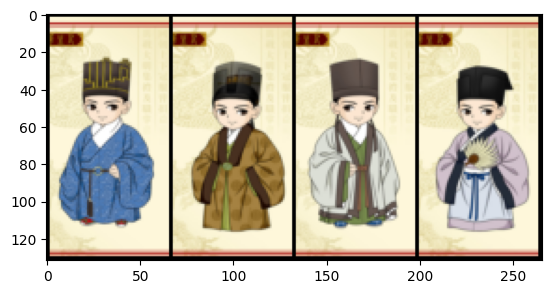

In [10]:
show_images(x)

In [11]:
# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = UNet2DModel(
    sample_size=(128, 64),  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
net.to(device)
sum([p.numel() for p in net.parameters()])

18536323

In [12]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [13]:
# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-5) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
with TimerContext():
    for epoch in range(100):
    
        for x in train_dataloader:
    
            # Get some data and prepare the corrupted version
            x = x.to(device) # Data on the GPU
            noise = torch.randn(x.shape).to(x.device)
            bs = x.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, 
                noise_scheduler.num_train_timesteps, ## 前两个参数指的是生成数组的取值范围？
                (bs,), ## 这个是数组的长度？
                device=x.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            noisy_images = noise_scheduler.add_noise(x, noise, timesteps)

            noise_pred = net(noisy_images, timesteps, return_dict=False)[0]

            # Calculate the loss
            loss = loss_fn(noise_pred, noise) 
    
            # Backprop and update the params:
            opt.zero_grad()
            loss.backward()
            opt.step()
    
            # Store the loss for later
            losses.append(loss.item())
    
        # Print our the average of the loss values for this epoch:
        avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
        print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

start time: 2024-09-20 17:32:20.422980


/home/xiuminke/.local/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Finished epoch 0. Average loss for this epoch: 1.083512
Finished epoch 1. Average loss for this epoch: 0.983452
Finished epoch 2. Average loss for this epoch: 0.901157
Finished epoch 3. Average loss for this epoch: 0.804073
Finished epoch 4. Average loss for this epoch: 0.729929
Finished epoch 5. Average loss for this epoch: 0.676296
Finished epoch 6. Average loss for this epoch: 0.643080
Finished epoch 7. Average loss for this epoch: 0.563874
Finished epoch 8. Average loss for this epoch: 0.538305
Finished epoch 9. Average loss for this epoch: 0.483968
Finished epoch 10. Average loss for this epoch: 0.452338
Finished epoch 11. Average loss for this epoch: 0.417522
Finished epoch 12. Average loss for this epoch: 0.414234
Finished epoch 13. Average loss for this epoch: 0.336701
Finished epoch 14. Average loss for this epoch: 0.337492
Finished epoch 15. Average loss for this epoch: 0.314614
Finished epoch 16. Average loss for this epoch: 0.325800
Finished epoch 17. Average loss for this 

In [14]:
from diffusers import DDPMPipeline
image_pipe = DDPMPipeline(unet=net, scheduler=noise_scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

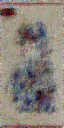

In [15]:
pipeline_output = image_pipe()
pipeline_output.images[0]